In [3]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('video_game_data.csv')
print(df.shape)
df.sample(5)

(48857, 9)


,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,tags
32770,46700,Ironclads American Civil War,True,False,False,Mostly Negative,20,29,"['Strategy', 'Naval']"
27209,533558,DEAD OR ALIVE 5 Last Round Core Fighters Add D...,True,False,False,Mixed,60,10,['Action']
15909,1837750,Demeo PC Edition,True,False,False,Very Positive,81,425,"['Adventure', 'Tabletop', 'RPG', 'Roguelite', ..."
37435,478950,V ARRR,True,False,False,Mixed,64,77,"['Action', 'Adventure', 'Indie', 'Simulation',..."
37648,1149290,Derpy Conga,True,False,False,Mostly Positive,76,17,"['Physics', 'Puzzle', 'Platformer', '3D Platfo..."


In [5]:
def imp_preprocess(dataset):
    dataset['tags']=dataset['tags'].apply(lambda x:" ".join(ast.literal_eval(x)))
    
    dataset['win']=dataset['win'].map({True:1,False:0})
    dataset['mac']=dataset['mac'].map({True:1,False:0})
    dataset['linux']=dataset['linux'].map({True:1,False:0})
    
    dataset['rating']=dataset['rating'].map({'Overwhelmingly Positive':1,'Very Positive':2,'Positive':3,'Mostly Positive':4,'Mixed':5,'Mostly Negative':6,'Negative':7,'Very Negative':8,'Overwhelmingly Negative':9})
    
    dataset['user_reviews'] = np.log1p(dataset['user_reviews'])  # handles 0 safely
    
    dataset['title']=dataset['title'].str.lower()
    dataset=dataset[~dataset['title'].duplicated(keep=False)]
    return dataset
df=imp_preprocess(df)

In [6]:
df.sample(5)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,tags
25229,1277710,robodo,1,0,0,3,81,2.484907,Multiplayer Casual 3D Platformer Puzzle Platfo...
9620,1393820,prodigal,1,0,0,2,96,5.023881,Action RPG Dating Sim Dungeon Crawler 2D Puzzl...
42784,1570340,dawn of the falkonir,1,0,0,5,55,3.401197,Action-Adventure 3D Platformer Fantasy Magic C...
435,462680,balancity,1,1,1,2,82,6.318968,Physics City Builder Puzzle Casual Simulation ...
40742,954080,memorrha,1,1,1,5,63,4.744932,Puzzle Singleplayer Indie Adventure Walking Si...


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rb=RobustScaler()
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.neighbors import NearestNeighbors

In [8]:
def model_training(df):
    to_scale=['positive_ratio','user_reviews']
    X=df[to_scale]
    xtrain,xtest=train_test_split(X,test_size=0.2,random_state=42)
    xtrain_scaled=rb.fit(xtrain)
    X_scaled=rb.transform(X)
    tfidf=TfidfVectorizer(stop_words='english')
    tfidf_tags=tfidf.fit_transform(df['tags'].fillna(''))
    combine=hstack([X_scaled,tfidf_tags])
    combine=combine.tocsr()
    nn=NearestNeighbors(metric='cosine',algorithm='brute')
    nn.fit(combine)
    return combine,nn,df
combine,nn,df=model_training(df)

In [9]:
def recommendation(combine,nn,df,game_title,top_games=5):
    try:
        game_index=df[df['title']==game_title.lower()].index[0]
        dist,indices=nn.kneighbors(combine[game_index],n_neighbors=top_games+1)
        searched=df[df['title']==game_title][['title', 'positive_ratio', 'user_reviews', 'tags']]
        recommend=df.iloc[indices[0][1:]][['title','positive_ratio','user_reviews','tags']]
        result=pd.concat([searched,recommend])
        return result
    except:
        return 'NO DATA FOUND'

game_title='grand theft auto'
result=recommendation(combine,nn,df,game_title,5)

In [10]:
result

,title,positive_ratio,user_reviews,tags
42927,grand theft auto,79,5.416100,Action Classic Automobile Sim Open World 2D Si...
26302,system goose overload,88,4.276666,RPG Indie Adventure Free to Play Pixel Graphics
23205,book of potentia 2,73,4.653960,Free to Play Indie Roguelike Pixel Graphics
6018,tower fortress,93,4.406719,Action Indie Adventure Pixel Graphics Roguelik...
41142,snout,91,5.204007,Action Casual Arcade 2D Pixel Graphics Free to...
42541,towards the pantheon escaping eternity,90,4.787492,Free to Play Adventure RPG Indie Casual Horror...


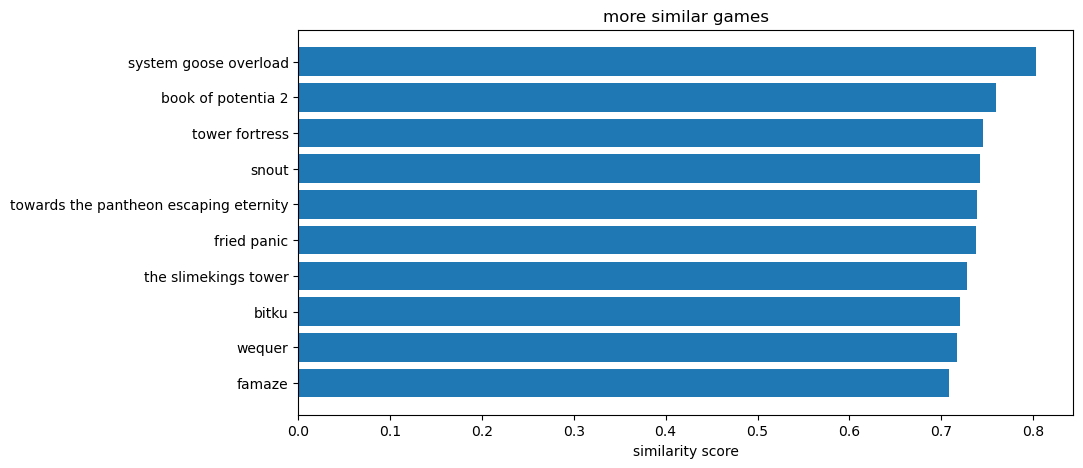

In [11]:
def similarity_check(combine,nn,df,game_title,top_games=10):
    try:
        game_index=df[df['title']==game_title.lower()].index[0]
        dist,indices=nn.kneighbors(combine[game_index],n_neighbors=top_games+1)
        score=1-dist[0][1:]
        titles=df.iloc[indices[0][1:]]['title']
        plt.figure(figsize=(10,5))
        plt.barh(titles[::-1],score[::-1])
        plt.xlabel('similarity score')
        plt.title('more similar games')
        plt.show()
    except:
        print('No Game Found')

game_title='grand theft auto'
similarity_check(combine,nn,df,game_title)

In [12]:
#df

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,tags
0,13500,prince of persia warrior within,1,0,0,2,84,7.696213,Action Adventure Parkour Third Person Great So...
1,22364,brink agents of change,1,0,0,3,85,3.091042,Action
2,113020,monaco whats yours is mine,1,1,1,2,92,8.222285,Co-op Stealth Indie Heist Local Co-Op Strategy...
3,226560,escape dead island,1,0,0,5,61,6.773080,Zombies Adventure Survival Action Third Person...
4,249050,dungeon of the endless,1,1,0,2,88,9.080801,Roguelike Strategy Tower Defense Pixel Graphic...
...,...,...,...,...,...,...,...,...,...
48852,2455060,taboo trial,1,0,0,2,94,6.204558,RPG Indie Nudity Action Roguelike Female Prota...
48853,1138640,hometopia,1,0,0,5,61,5.517453,Early Access Life Sim City Builder Immersive S...
48854,2515460,northgard kernev clan of the stoat,1,1,1,5,67,4.394449,Strategy Indie Simulation
48855,1687000,fading afternoon,1,0,0,4,79,5.883322,Side Scroller Beat 'em up Sandbox Martial Arts...


In [99]:
#df[df['rating']==9]

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,tags
3185,1180320,war of the three kingdoms,1,0,0,9,15,9.965382,Sexual Content Free to Play Solitaire Card Gam...
3371,1416420,expansion europa universalis iv leviathan,1,1,1,9,10,8.460411,Alternate History Grand Strategy RTS Education...
12656,512032,sid meiers civilization vi vikings scenario pack,1,1,1,9,15,7.077498,Strategy Vikings
21238,1850380,tricolour lovestory trueend,1,0,0,9,14,7.461640,Adventure Indie Casual
21822,2016940,o2jam online,1,0,0,9,17,7.432484,Casual Rhythm Relaxing Colorful Score Attack O...
27522,1799220,malice,1,0,0,9,16,6.584791,Escape Room Online Co-Op Puzzle Atmospheric Ho...
28238,267600,airport simulator 2014,1,0,0,9,13,6.317165,Simulation Management Singleplayer Strategy Me...
29718,1563130,superpower 3,1,0,0,9,10,6.781058,Strategy Simulation Grand Strategy RTS Politic...
32960,201510,flatout 3 chaos destruction,1,0,0,9,15,7.925519,Psychological Horror Combat Racing Racing Auto...
33223,1162602,tekken 7 dlc13 frame data display,1,0,0,9,14,6.406880,Action Sports


In [12]:
#df[df['title']=='drift']

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,tags
48837,2159650,drift,1,1,1,5,69,3.610918,Open World Survival Craft Survival Online Co-O...
